# 01: Read files and Preprocessing

In [1]:
import gzip

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
# 分子の標準化を行うためのモジュールを読み込む
from rdkit.Chem import MolStandardize
from rdkit.Chem import Descriptors
import pandas as pd

from IPython.display import display

In [2]:
machine = "local"
if machine == "local":
    data_dir = "/Users/RSuzuki/Projects/data/souyakuchan_library"

SDFフォーマットについて：https://future-chem.com/mol-sdf/

In [3]:
!head $data_dir"/Enamine_Premium_collection.sdf"


  -ISIS-  -- StrEd -- 

 15 16  0  0  0  0  0  0  0  0999 V2000
   -0.3872    2.5353    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3872    1.5352    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4217    0.9475    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.1129   -0.0037    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8872   -0.0037    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1963    0.9475    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0


In [3]:
df = PandasTools.LoadSDF(f"{data_dir}/Enamine_Premium_collection.sdf", embedProps=True, molColName=None, smilesName='smiles')

In [4]:
display(df)

,idnumber,heavy_atoms,LogS,LogP,rotating_bonds,PSA,hb_acceptors,hb_donors,ID,smiles,SaltType
0,Z1498649509,15,-0.138,0.38,3,65.04,4,2,,Cc1nc(C2CCCCN2CCO)n[nH]1,NaN
1,Z1716308299,17,-2.06,0.551,4,74.17,4,1,,CC(C)Cc1noc(C2CCC(CN)O2)n1.Cl,Cl
2,Z1815187669,17,-1.48,0.421,3,74.17,4,1,,CC(C)(C)c1noc(C2CCC(CN)O2)n1.Cl,Cl
3,Z1522355895,16,-1.846,0.813,2,47.26,3,1,,N#CCN1CC(O)CC1c1ccc(F)cc1,NaN
4,Z1493895982,16,0.042,0.028,6,41.93,4,1,,OCCOCCN1CCC(C2CCOC2)C1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
128811,Z2677923079,19,-1.109,0.602,6,51.97,4,1,,CCOC1CCC(CNC(C)c2ncn(C)n2)CC1,NaN
128812,Z2677923099,24,-1.564,2.312,4,45.4,4,0,,Cc1noc(C2CN(CC3CC3c3ccc(F)cc3)CCN2C)n1,NaN
128813,Z2677923175,20,-2.508,1.844,6,42.74,3,1,,CC(NCC[C@@H]1C[C@H]1c1ccccc1)c1ncn(C)n1,NaN
128814,Z2677923177,24,-1.87,2.698,5,45.4,4,0,,Cc1noc(C2CN(CC[C@@H]3C[C@H]3c3ccccc3)CCN2C)n1,NaN


In [15]:
EPc_mols_pro = []
cnt = 0
# instantiate
normalizer =MolStandardize.normalize.Normalizer()
lfc = MolStandardize.fragment.LargestFragmentChooser()
uc = MolStandardize.charge.Uncharger()

for mol in Chem.SDMolSupplier(f"{data_dir}/Enamine_Premium_collection.sdf"):
    # if cnt > 3:
    #     break
    # cnt += 1
    if mol is not None:
        id = mol.GetProp('idnumber') 
        mol_norm = normalizer.normalize(mol)
        mol_desalt = lfc.choose(mol_norm)
        mol_neu = uc.uncharge(mol_desalt)
        mol_neu.SetProp('original_id', id)
        MW_value = Descriptors.MolWt(mol)
        mol_neu.SetDoubleProp('MW', MW_value)
        EPc_mols_pro.append(mol_neu)

128816


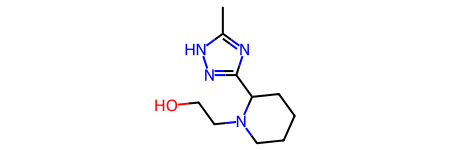

In [17]:
print(len(EPc_mols_pro))
EPc_mols_pro[0]

In [18]:
#構造とidnumber、original_id、MWをもつsdfファイルを作成
writer = Chem.SDWriter(f'{data_dir}/preprocessed/Enamine_Premium_collection_pp_id_MW.sdf')

#プロパティとして持たせたいものをリストにしておく
prop_names = ['idnumber', 'original_id', 'MW']

writer.SetProps(prop_names)
for mol in EPc_mols_pro:
  writer.write(mol)
writer.close()

In [21]:
df_active_cpds = pd.read_csv(f'{data_dir}/PD1_inhibitor_dataset.csv')

In [23]:
df_active_cpds.head()

,compound_id,patent_no,example_no,schembl_id,applicant,smiles
0,BMS-M1,WO2014151634,1173,SCHEMBL16128545,BMS,CCCC[C@H]1C(=O)N[C@H](C(=O)N[C@@H](CSCC(=O)N[C...
1,BMS-1,WO2015034820,202,SCHEMBL16566296,BMS,COC1=C(CNCCNC(C)=O)C=CC(OCC2=C(C)C(=CC=C2)C2=C...
2,BMS-2,WO2015160641,1305,SCHEMBL17161828,BMS,CC(=O)NCCNCC1=C(OCC2=CN=CC(=C2)C#N)C=C(OCC2=C(...
3,BMS-M2,WO2016039749,10091,NaN,BMS,CCCC[C@H]9C(=O)N1CCC[C@@H]1C(=O)N[C@@H](CC(=O)...
4,BMS-M3,WO2016057624,9007,SCHEMBL17679582,BMS,CCCC[C@@H]1N(C)C(=O)[C@H](CCCC)N(C)C(=O)[C@H](...


In [26]:
PandasTools.AddMoleculeColumnToFrame(df_active_cpds, 'smiles')

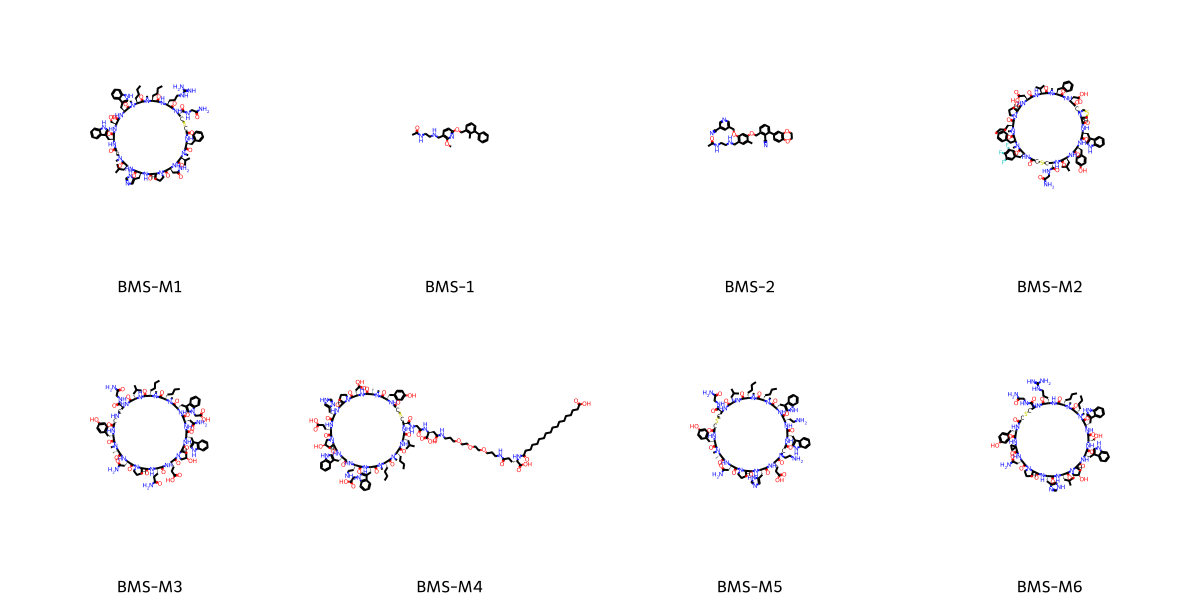

In [33]:
PandasTools.FrameToGridImage(df_active_cpds[:8], column='ROMol', legendsCol='compound_id', molsPerRow=4, subImgSize=(300,300))

In [35]:
df_active_cpds['MW'] = df_active_cpds.ROMol.map(Descriptors.MolWt)

In [37]:
df_active_cpds["MW"].describe()

count      53.000000
mean      819.726075
std       626.128326
min       215.213000
25%       419.525000
50%       574.899000
75%       753.340000
max      2699.165000
Name: MW, dtype: float64

<AxesSubplot:>

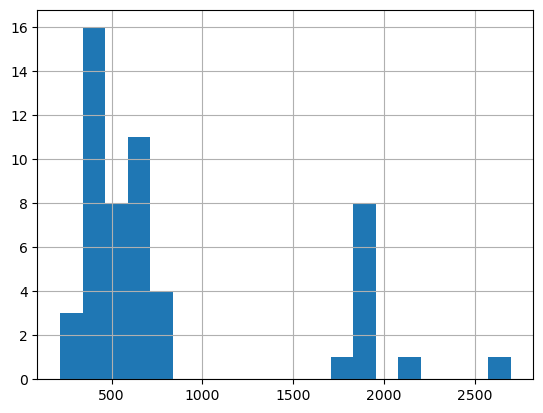

In [40]:
df_active_cpds["MW"].hist(bins=20)

In [4]:
EPc_mols = [mol for mol in Chem.SDMolSupplier(f"{data_dir}/Enamine_Premium_collection.sdf") if mol is not None]

In [7]:
print(len(EPc_mols))

128816


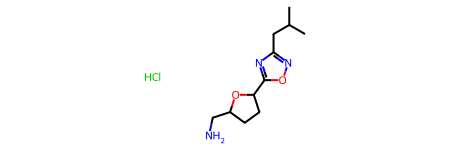

In [15]:
EPc_mols[1]

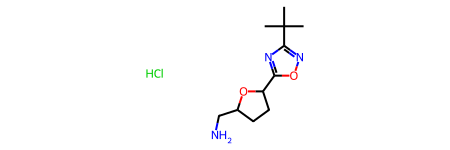

In [16]:
EPc_mols[2]

In [19]:
list(EPc_mols[2].GetPropNames())

['idnumber',
 'heavy_atoms',
 'LogS',
 'LogP',
 'rotating_bonds',
 'PSA',
 'hb_acceptors',
 'hb_donors',
 'SaltType']

In [21]:
#標準化
normalizer =MolStandardize.normalize.Normalizer()
test_mol_norm = normalizer.normalize(EPc_mols[2])

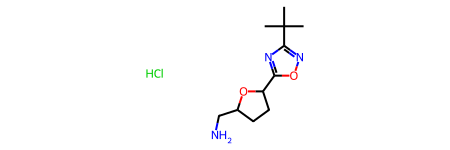

In [23]:
EPc_mols[2]

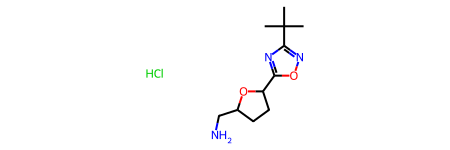

In [22]:
test_mol_norm

In [27]:
#一番大きいサイズのフラグメントのみ残す（ここで脱塩されるみたい）
lfc = MolStandardize.fragment.LargestFragmentChooser()
test_mol_desalt = lfc.choose(test_mol_norm)

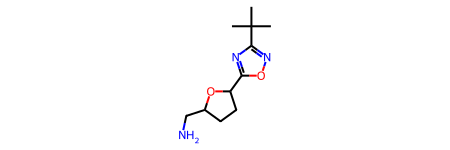

In [28]:
test_mol_desalt

In [29]:
#電荷の中和
uc = MolStandardize.charge.Uncharger()
test_mol_neu = uc.uncharge(test_mol_desalt)

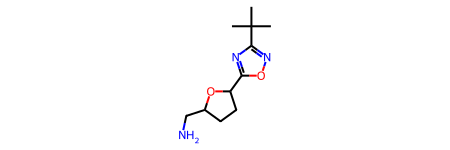

In [30]:
test_mol_neu